In [1]:
from os.path import join
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile
from nltk.tokenize import sent_tokenize, word_tokenize

In [2]:
path='train/'

files = [f for f in listdir(path) if isfile(join(path, f))]

len(files)

202

In [3]:
import xml.etree.ElementTree as ET
import re


def xml2df(xml_data,i):
    #xml_data=re.sub(u"(\u2018|\u2019)", "'", xml_data)
    tree = ET.parse(xml_data) #Initiates the tree Ex: <user-agents>
    
    all_records = [] #This is our record list which we will convert into a dataframe
    headers = [] #Subchildren tags will be parsed and appended here
    record = []
    attrib=[]
    values=[]
    label=[]
    tex=""
    for elem in tree.iter(): #Begin looping through our root tree
        if(elem.tag!='PatientMatching' and elem.tag!='TAGS'):
            headers.append(elem.tag)
            record.append(elem.text)
            attrib.append(elem.attrib.get('met'))
            
    text = record[0]
    
    file = open("TEXT/"+str(i)+".txt","w+") 
    file.write(record[0])
    file.close() 
    
    all_records.append(text)
    for a in attrib[1:]:
        if(a == 'met'):
            label.append(1)
        else:
             label.append(0)
    all_records.append(label)
    all_records.append(i)
    return pd.DataFrame([all_records], columns=['text','label','name']) 

In [4]:
data = None
for file in files:
    #print(str(i)+"/"+str(len(files)), end='\r')
    df = xml2df(join(path,file),file.split(".")[0])
    if data is None: data = df
    else: data = data.append(df,ignore_index=True)
    
data = data.convert_objects(convert_numeric=True)

C:\Users\rezvanjoshaghani\AppData\Roaming\Python\Python36\site-packages\ipykernel\__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
data.head()

,text,label,name
0,\n\nRecord date: 2106-02-12\n\nCampbell Orthop...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]",100
1,\n\nRecord date: 2079-05-12\n\n\n\n\n\nMERCY C...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",101
2,\n\nRecord date: 2120-09-19\n\nPersonal Data a...,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]",102
3,\n\nRecord date: 2067-11-24\n\n ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",103
4,\n\nRecord date: 2094-02-16\n\nJENNIFER BOOKER...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]",104


In [6]:
path='TA/'

files = [f for f in listdir(path) if isfile(join(path, f))]

len(files)

202

In [7]:

def isgood(x):
    gs=""
    expr = re.compile('.*g1.*|.*g2.*|.*g3a.*|.*g3b.*|.*g4.*|.*g5.*|.*ckd.*|.*a2.*|.*a3.*|.*acr.*|.*diabet.*|'+
                      '.*kidney|.*eye.*|.*skin.*|.*retinopathy.*|.*nephropathy.*|.*neuropathy.*')
    w=word_tokenize(x)
    for a in w:  
        if re.match(expr,a.lower()):
            return True

In [8]:
import re
def cleanText(a):
    temp=[]
    pf = open(join(path,str(a)+".txt"),'r')
    st=pf.read()
    texts =st.split("\n")

    for text in texts:
        try:
            found = re.search('semantic=(.+?)(\t*)assertion=(.+?)(\t*)ne=(.+)', text)
            sem = found.group(1)
            stat = found.group(3)
            elem = found.group(5)
        except AttributeError:
            # AAA, ZZZ not found in the original string
            found = '' # apply your error handling
        if(stat=="present"):
            #temp.append(sem)
            #temp.append(stat)
            if(isgood(elem)):
                abc=elem.split(" ")
                temp.extend(abc)
    return temp

In [9]:
data['split']=data.name.map(lambda x: cleanText(x))

In [10]:
data['split']=data.split.map(lambda x: [a.lower() for a in x] )

In [11]:
data.head()

,text,label,name,split
0,\n\nRecord date: 2106-02-12\n\nCampbell Orthop...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]",100,"[diabetes, a, diabetic, diabetes, l, eye, visu..."
1,\n\nRecord date: 2079-05-12\n\n\n\n\n\nMERCY C...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",101,[]
2,\n\nRecord date: 2120-09-19\n\nPersonal Data a...,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]",102,"[diabetes, diabetic, medications, diabetes, re..."
3,\n\nRecord date: 2067-11-24\n\n ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",103,"[non-insulin-dependent, diabetes, diabetes, me..."
4,\n\nRecord date: 2094-02-16\n\nJENNIFER BOOKER...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]",104,"[uti, in, diabetic, diabetes, mellitus, neurop..."


In [12]:
import nltk
from sklearn import preprocessing
we = preprocessing.LabelEncoder()
pstemmer = nltk.lancaster.LancasterStemmer()

vocab  = set([pstemmer.stem(i) for x in data.split for i in x])

In [13]:
len(vocab)

462

In [14]:
we.fit(list(vocab)) 

LabelEncoder()

In [15]:
data['ind'] = data.split.map(lambda x: [we.transform([pstemmer.stem(i)])[0] for i in x])

In [16]:
data['db']=data.label.map(lambda x: x[10])

In [17]:
data.head()

,text,label,name,split,ind,db
0,\n\nRecord date: 2106-02-12\n\nCampbell Orthop...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]",100,"[diabetes, a, diabetic, diabetes, l, eye, visu...","[126, 16, 126, 126, 231, 169, 451, 142, 375, 4...",1
1,\n\nRecord date: 2079-05-12\n\n\n\n\n\nMERCY C...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",101,[],[],0
2,\n\nRecord date: 2120-09-19\n\nPersonal Data a...,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]",102,"[diabetes, diabetic, medications, diabetes, re...","[126, 126, 266, 126, 352, 448, 271, 126, 352, ...",1
3,\n\nRecord date: 2067-11-24\n\n ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]",103,"[non-insulin-dependent, diabetes, diabetes, me...","[290, 126, 126, 268, 126, 126, 126, 126]",0
4,\n\nRecord date: 2094-02-16\n\nJENNIFER BOOKER...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]",104,"[uti, in, diabetic, diabetes, mellitus, neurop...","[446, 211, 126, 126, 268, 283, 126, 268, 126, ...",1


In [18]:
data.to_pickle('majorDiabeties.pkl')

In [19]:
from keras.preprocessing import sequence

data['lens'] = data.ind.map(lambda x: len(x))
maxlen = max(data.lens)
maxlen

Using TensorFlow backend.


13710

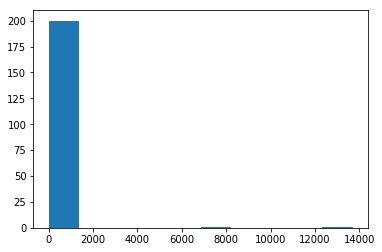

In [20]:
import matplotlib.pyplot as plt
plt.hist(data.lens)
plt.show()

In [21]:
data = data[data.lens < 5000]
maxlen = max(data.lens)

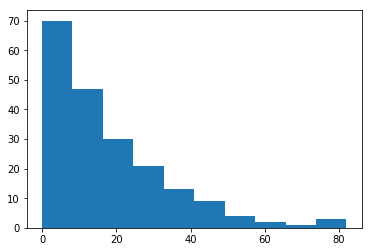

In [22]:
import matplotlib.pyplot as plt
plt.hist(data.lens)
plt.show()

In [23]:
#datac=datac.sample(frac=0.05)
train=data.sample(frac=0.8,random_state=200)
test=data.drop(train.index)

train.shape, test.shape

((160, 7), (40, 7))

In [24]:
X_train = sequence.pad_sequences(train.ind, maxlen=maxlen)
X_train = np.array([x.ravel() for x in X_train])

In [25]:
y_train = np.array([x for x in train.db])
y_train.shape

(160,)

In [26]:
import numpy
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing import sequence
import numpy as np
import random


model = Sequential()
model.add(Embedding(len(vocab), maxlen, input_length=X_train.shape[1]))
model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 82, 82)            37884     
_________________________________________________________________
dense_1 (Dense)              (None, 82, 200)           16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 82, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 174,985
Trainable params: 174,985
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
160/160 [==============================] - 2s 11ms/step - loss: 0.6808 - acc: 0.5938
Epoch 2/10
160/160 [==============================] - 1s 5ms/step - loss: 0.7544 - acc: 0.6188
Epoch 3/10
160/160 [==============================] - 1s 5ms/step - loss: 0.6182 - acc: 0.7625
Epoch 4/10
160/160 [==============================] - 1s 5ms/step - loss: 0.5200 - acc: 0.8063
Epoch 5/10
160/160 [==============================] - 1s 4ms/step - loss: 0.3909 - acc: 0.8563
Epoch 6/10
160/160 [==============================] - 1s 4ms/step - loss: 0.3632 - acc: 0.8688
Epoch 7/10
160/160 [==============================] - 1s 4ms/step - loss: 0.2839 - acc: 0.9062
Epoch 8/10
160/160 [==============================] - 1s 4ms/step - loss: 0.2693 - acc: 0.8937
Epoch 9/10
160/160 [==============================] - 1s 4ms/step - loss: 0.3045 - acc: 0.8812
Epoch 10/10
160/160 [==============================] - 1s 4ms/step - loss: 0.2247 - acc: 0.9250


In [28]:
model.save('Trained Models/model-majorDiabities.h5')

In [29]:
X_test = sequence.pad_sequences(test.ind, maxlen=maxlen)
X_test = np.array([x.ravel() for x in X_test])

In [30]:
Y_test = np.array([x for x in test.db])
Y_test

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1], dtype=int64)

In [31]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.828360369802
Test accuracy: 0.725


In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test, Y_test)

0.57499999999999996

In [33]:
guess = model.predict_classes(X_test)
guess = [g[0] for g in guess]
gold = Y_test
guess[:5], gold[:5]

([0, 1, 1, 0, 1], array([0, 1, 0, 0, 1], dtype=int64))

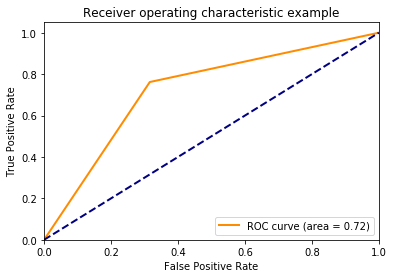

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 

x, y, _ = metrics.roc_curve(gold, guess)
auc = metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

